# Courbe ROC et AUC

## Introduction

En plus des métriques de precision, recall et F1 score, il existe un autre outil qui permet de mesurer les performances d'un modèle de classification : la courbe ROC (ROC Curve).

La courbe ROC et sa mesure associée l'AUC (Aire sous la courbe) permettent d'évaluer les performances globales d'un modèle mais aussi de comparer facilement les performances de plusieurs modèles de classifications entre eux. 

La courbe ROC est donc un outil qui peut faciliter notre décision concernant le choix du modèle de classification à utiliser.

## Partie théorique 

Lorsqu'un modèle de classification fait une prédiction sur une observation, il va lui attribuer une des classes disponibles. Par exemple si notre modèle doit prédire si une image contient un chien ou un chat, alors les classes seront chien ou chat. On peut définir que la classe chien sera la classe positive, qu'on cherche à detecter, et la classe chat sera la classe négative.

Pour choisir dans quelle classe placer une observation, le modèle va utiliser le score de la fonction de décision. Plus ce score est élevé, plus la prédiction est susceptible d'être positive. C'est une estimation de la probabilité que ce qu'on doit prédire soit positif.

Afin de choisir comment classer les observations entre ces deux classes on va utiliser un **seuil** (treshold). Si la valeur du score de la fonction de décision est supérieur au seuil, alors l'observation sera prédite comme positive, si elle est inférieur, alors elle sera prédite négative.

## Partie pratique

### Création d'un jeu de données pour la classification

In [87]:
# Importation des librairies

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_predict

In [88]:
# Création d'un jeu de données avec deux classes à prédire

X, y = make_classification(n_samples=1000, n_features=10, n_informative=3, n_classes=2, weights= [0.7], random_state=42)

In [89]:
# Création des train et test set

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.8, random_state=42, stratify=y)

### Entrainement du modèle

On va entrainer deux modèles pour montrer l'utilisation de la courbe ROC et AUC.

In [90]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# Entrainement de plusieurs modèles de classifications

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# On sauvegarde les prédictions faites sur le train test pour les modèles

y_train_pred_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
y_train_pred_rf = cross_val_predict(rf_clf, X_train, y_train, cv=3)

### Rappel sur les métriques

Lorsque l'on souhaite mesurer les performances d'un modèle de classification on dispose de plusieurs métriques : 

- L'accuracy -> Le nombre total de prédictions correctes parmis toutes les observations
- Le recall -> Le nombre d'obervations positives correctement prédits parmi tous les observations positives réelles
- La precision -> le nombre de prédictions correctes parmi les observations positives prédites
- Le F1 score -> Une combinaison entre le recall et la precision

On peut également représenter les prédictions du modèle dans une matrice de confusion, qui permet de mieux comprendre les prédictions faites par le modèle et ses erreurs.

In [91]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve

# On crée la matrice de confusion en passant les classes et les prédictions du modèle
cm = cm = confusion_matrix(y_train, y_train_pred_sgd)
conf_matrix = pd.DataFrame(cm, index=["Actual Class 0", "Actual Class 1"], columns=["Predicted Class 0", "Predicted Class 1"])

display(conf_matrix)

print("Score du recall : ", recall_score(y_train, y_train_pred_sgd))
print("Score de la precision : ", precision_score(y_train, y_train_pred_sgd))
print("Score F1 : ", f1_score(y_train, y_train_pred_sgd))

,Predicted Class 0,Predicted Class 1
Actual Class 0,532,24
Actual Class 1,45,199


Score du recall :  0.8155737704918032
Score de la precision :  0.8923766816143498
Score F1 :  0.8522483940042827


On peut aussi visualiser sur un graphique l'évolution de la précision et du recall en fonction du seuil.

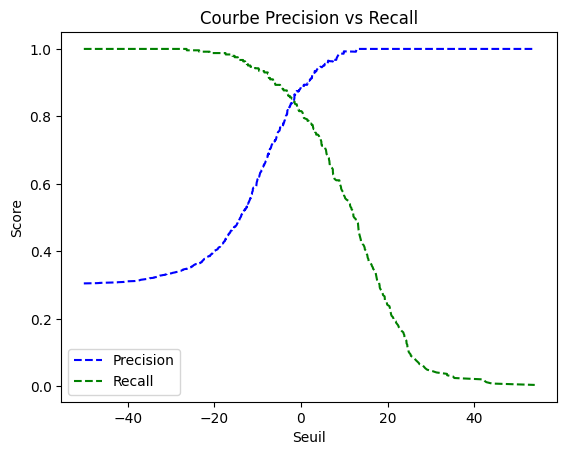

In [93]:
# Au lieu d'obtenir les prédictions, on récupere les scores de décisions pour chaque observations
y_scores_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function")

# A partir des scores de décisions on calcule les combinaisons de scores pour recall et precision en fonction du seuil
precisions, recalls, tresholds = precision_recall_curve(y_train, y_scores_sgd)

plt.plot(tresholds, precisions[:-1], "b--", label="Precision")
plt.plot(tresholds, recalls[:-1], "g--", label="Recall")

plt.title("Courbe Precision vs Recall")
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.legend()

plt.show()

On peut également représenter l'évolution de la precision en fonction du recall.

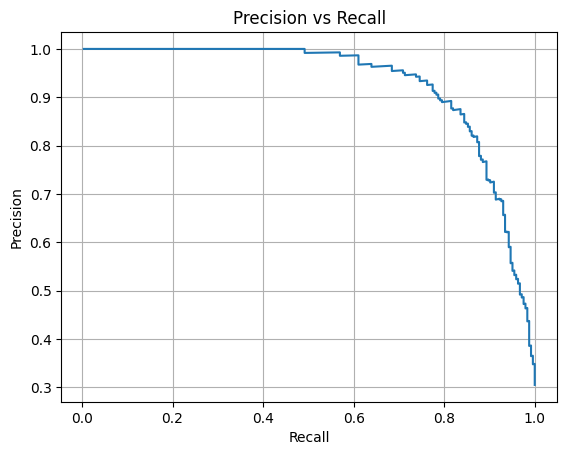

In [95]:
plt.plot(recalls[:-1], precisions[:-1])

plt.title("Precision vs Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

plt.show()

### Choix d'un seuil suivant un score de métrique

Lorsque l'on cherche à optimiser une métrique plutôt qu'une autre on va vouloir diminuer ou augmenter notre seuil.
Dans le cas ou on souhaite augmenter la precision, on augmente le seuil.
Dans le cas ou on souhaite augmenter le recall, on diminue le seuil.

Voici le code si on souhaite obtenir un score de precision de 0,9.

In [98]:
# On cherche dans nos seuils une valeur pour laquelle la precision est supérieur à 0.9
treshold_90_precision = tresholds[np.argmax(precisions >= 0.90)]
print("Seuil pour obtenir une precision de 90% : ", treshold_90_precision)

# On crée de nouvelle prédictions ou la classe sera positive seulement si son score est supérieur au seuil permettant d'avoir 90% de précision
y_train_pred_90 = (y_scores_sgd >= treshold_90_precision)

display(precision_score(y_train, y_train_pred_90))
display(recall_score(y_train, y_train_pred_90))

Seuil pour obtenir une precision de 90% :  1.5643506399766398


0.9014084507042254

0.7868852459016393

### Courbe ROC 

In [59]:
from sklearn.metrics import roc_curve, roc_auc_score

In [63]:
fpr, tpr, tresholds = roc_curve(y_train, y_scores)

In [64]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.title("Courbe ROC")
    plt.xlabel("Taux de Faux Positif")
    plt.ylabel("Taux de Vrai Positif")
    plt.grid()

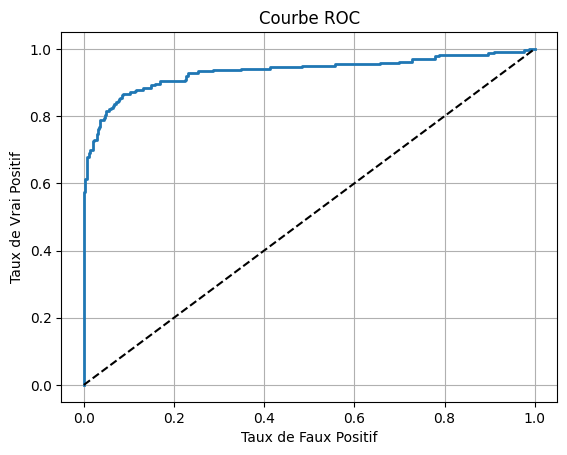

In [65]:
plot_roc_curve(fpr, tpr)
plt.show()

In [66]:
display(roc_auc_score(y_train, y_scores))

0.9337425595238095

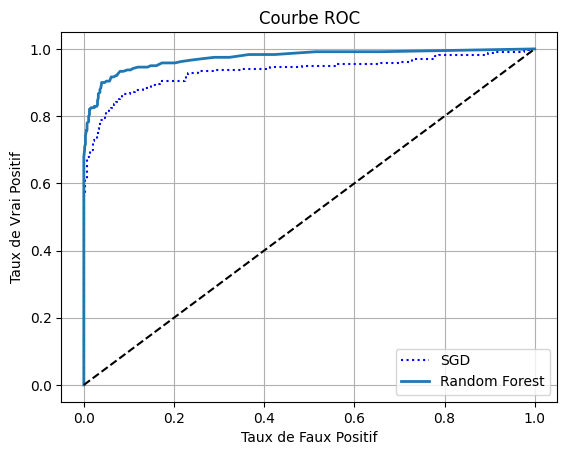

0.9734300595238096

In [67]:
forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=5, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

display(roc_auc_score(y_train, y_scores_forest))